# MURA, Abnormal X-ray Classification, Stanford

MURA is a dataset of bone X-rays that allows to create models that find abnormalities. Fastai v1 allows to create such a world-class model as part of the MURA competition, which evaluates the performance of a study classifier using the kappa score.

## What is MURA?
MURA (**MU**sculoskeletal **RA**diographs) is a large dataset of bone X-rays that allows to create models that determines whether an X-ray study is normal or abnormal (we could use as well this dataset to classify bones into the categories shoulder, humerus, elbow, forearm, wrist, hand, and finger). MURA is one of the largest public radiographic image datasets.

https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Libraries 

In [0]:
import os 
import zipfile

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob

In [0]:
from fastai.vision import *
from fastai.widgets import *
import shutil

from fastai.callbacks import *
import fastai
import gc
import torch

print('Ver. fastai: ', fastai.__version__)
print('Ver. Pytorch: ', torch.__version__)
print('CUDA: ', torch.cuda.is_available())

Ver. fastai:  1.0.59
Ver. Pytorch:  1.3.1
CUDA:  True


## Data

### Download and Set a data path

In [0]:
!wget \
  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip \
  -O /tmp/MURA.zip

--2019-12-30 03:39:05--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘/tmp/MURA.zip’

/tmp/MURA.zip       100%[===================>]   3.15G  14.1MB/s    in 3m 54s  

2019-12-30 03:42:58 (13.8 MB/s) - ‘/tmp/MURA.zip’ saved [3380245855/3380245855]



In [0]:
os.listdir('/tmp')

['drivefs_ipc.0', 'drivefs_ipc.0_shell', 'MURA.zip', 'tmpid_x3_2g']

In [0]:
local_zip = '/tmp/MURA.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
path = '/tmp/MURA-v1.1/'

In [0]:
os.listdir(path)

['train_labeled_studies.csv',
 'valid_labeled_studies.csv',
 'valid_image_paths.csv',
 'train',
 'train_image_paths.csv',
 'valid']

### Read csv files

In [0]:
df_train = pd.read_csv(path + 'train_image_paths.csv', header=None, names=['image'])
df_train.image[0]

'MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png'

In [0]:
df_valid = pd.read_csv(path + 'valid_image_paths.csv', header=None, names=['image'])
df_valid.image[0]

'MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png'

In [0]:
df_train_label = pd.read_csv(path + 'train_labeled_studies.csv', header=None, names=['image', 'label'])
df_train_label.head()

,image,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [0]:
df_valid_label = pd.read_csv(path + 'valid_labeled_studies.csv', header=None, names=['image', 'label'])
df_valid_label.head()

,image,label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1


### Create folder 'data2' to train models

In [0]:
path_train = path + 'data2/train/'
path_valid = path + 'data2/valid/'

os.mkdir(path + 'data2/')
os.mkdir(path_train)
os.mkdir(path_valid)

In [0]:
os.mkdir(path_train + '0/')
os.mkdir(path_train + '1/')

path_train_neg = path_train + '0/'
path_train_pos = path_train + '1/'

In [0]:
os.mkdir(path_valid + '0/')
os.mkdir(path_valid + '1/')

path_valid_neg = path_valid + '0/'
path_valid_pos = path_valid + '1/'

In [0]:
print(path_train_neg)
print(path_train_pos)
print(path_valid_neg)
print(path_valid_pos)

/tmp/MURA-v1.1/data2/train/0/
/tmp/MURA-v1.1/data2/train/1/
/tmp/MURA-v1.1/data2/valid/0/
/tmp/MURA-v1.1/data2/valid/1/


### Get list of images

In [0]:
fnames_train = get_image_files(path + 'train', recurse=True)
print(len(fnames_train))
fnames_train[:5]

36808


[PosixPath('/tmp/MURA-v1.1/train/XR_FOREARM/patient09133/study1_positive/image1.png'),
 PosixPath('/tmp/MURA-v1.1/train/XR_FOREARM/patient09133/study1_positive/image2.png'),
 PosixPath('/tmp/MURA-v1.1/train/XR_FOREARM/patient09133/study1_positive/image3.png'),
 PosixPath('/tmp/MURA-v1.1/train/XR_FOREARM/patient09111/study1_positive/image1.png'),
 PosixPath('/tmp/MURA-v1.1/train/XR_FOREARM/patient09111/study1_positive/image2.png')]

In [0]:
fnames_valid = get_image_files(path + 'valid', recurse=True)
print(len(fnames_valid))
fnames_valid[:5]

3197


[PosixPath('/tmp/MURA-v1.1/valid/XR_FOREARM/patient11417/study1_positive/image1.png'),
 PosixPath('/tmp/MURA-v1.1/valid/XR_FOREARM/patient11417/study1_positive/image2.png'),
 PosixPath('/tmp/MURA-v1.1/valid/XR_FOREARM/patient11417/study1_positive/image3.png'),
 PosixPath('/tmp/MURA-v1.1/valid/XR_FOREARM/patient11417/study1_positive/image4.png'),
 PosixPath('/tmp/MURA-v1.1/valid/XR_FOREARM/patient11248/study1_positive/image1.png')]

### Copy images into data2

In [0]:
pat_label = re.compile(r'/XR_([^/]+)/[^/]+/[^/]+/[^/]+.png$')
pat_patient = re.compile(r'/[^/]+/patient([^/]+)/[^/]+/[^/]+.png$')
pat_study = re.compile(r'/[^/]+/[^/]+/([^/]+)/[^/]+.png$')
# pat_study_negpos = re.compile(r'\\[^\\]+\\[^\\]+\\study\d+_([^\\]+)\\[^\\]+.png$')

In [0]:
%%time
# copy all train images in corresponding class folders under MURA-v1.1/data2/train
for src in fnames_train:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)  
    # create class folder if necessary
    if 'negative' in study:
        path_label = path_train_neg
    else:
        path_label = path_train_pos
    # copy image to its class folder
    img_name = label + '_patient' + patient + '_' + study + '_' + src.name
    dest = path_label + img_name
    shutil.copy(str(src), str(dest))

CPU times: user 3.23 s, sys: 4.62 s, total: 7.84 s
Wall time: 1min 20s


In [0]:
%%time
# copy all valid images in corresponding class folders under MURA-v1.1/data2/valid
for src in fnames_valid:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)  
    # create class folder if necessary
    if 'negative' in study:
        path_label = path_valid_neg
    else:
        path_label = path_valid_pos
    # copy image to its class folder
    img_name = label + '_patient' + patient + '_' + study + '_' + src.name
    dest = path_label + img_name
    shutil.copy(str(src), str(dest))

CPU times: user 253 ms, sys: 684 ms, total: 937 ms
Wall time: 8.21 s


### Number of studies

In [0]:
pat_label = re.compile(r'/XR_([^/]+)/[^/]+/[^/]+/[^/]+.png$')
pat_patient = re.compile(r'/[^/]+/patient([^/]+)/[^/]+/[^/]+.png$')
pat_study = re.compile(r'/([^/]+)_[^/]+/[^/]+.png$')

In [0]:
mura = ['elbow', 'finger', 'forearm', 'hand', 'humerus', 'shoulder', 'wrist']

study_train_dict = dict()
study_valid_dict = dict()

for m in mura:
    study_train_dict[m] = list()
    study_valid_dict[m] = list()
    
for src in fnames_train:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)
    # add to label list
    s = 'patient' + patient + '_' + study
    study_train_dict[label.lower()].append(s)

for src in fnames_valid:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)
    # add to label list
    s = 'patient' + patient + '_' + study
    study_valid_dict[label.lower()].append(s)

In [0]:
num_train_studies = 0
num_valid_studies = 0

for m in mura:
    # train
    myset = set(study_train_dict[m])
    num_train_studies += len(myset)
    # valid
    myset = set(study_valid_dict[m])
    num_valid_studies += len(myset)

In [0]:
# 207 studies in test
num_train_studies, num_valid_studies, num_train_studies + num_valid_studies + 207

(13457, 1199, 14863)

## Training with Resnet34

In [0]:
size = 112
bs = 256

np.random.seed(7)
data = ImageDataBunch.from_folder(path+'data2', ds_tfms=get_transforms(flip_vert=True, max_warp=0.), 
                                  size=size, bs=bs).normalize(imagenet_stats)

In [0]:
data

ImageDataBunch;

Train: LabelList (36808 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
1,1,1,1,1
Path: /tmp/MURA-v1.1/data2;

Valid: LabelList (3197 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
1,1,1,1,1
Path: /tmp/MURA-v1.1/data2;

Test: None

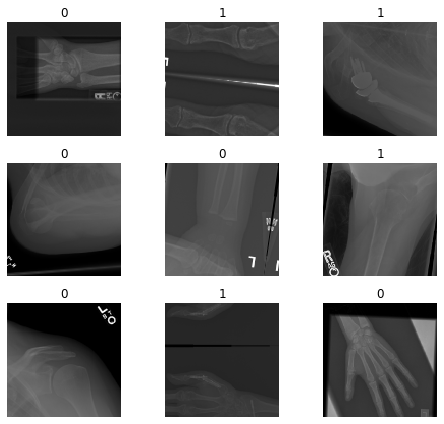

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)
print(data.c)

['0', '1']
2


In [0]:
len(data.train_ds), len(data.valid_ds), len(data.train_ds) + len(data.valid_ds)

(36808, 3197, 40005)

In [0]:
len(os.listdir(path_train_neg))

21935

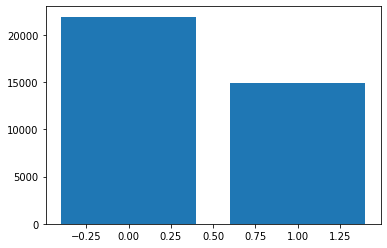

In [0]:
plt.bar([0, 1], [len(os.listdir(path_train_neg)), len(os.listdir(path_train_pos))])
plt.show()

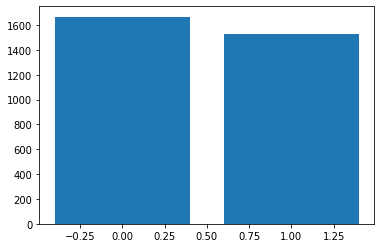

In [0]:
plt.bar([0, 1], [len(os.listdir(path_valid_neg)), len(os.listdir(path_valid_pos))])
plt.show()

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], wd=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 68.9MB/s]


### If you have **resnet34-stage-1**, jump to the second training phase or beyond.

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.855276,0.649719,0.376290,0.623710,05:37
1,0.649003,0.640242,0.363466,0.636534,05:38
2,0.610778,0.612380,0.328120,0.671880,05:29
3,0.584164,0.595932,0.319675,0.680325,05:29
4,0.576377,0.587892,0.315296,0.684704,05:34


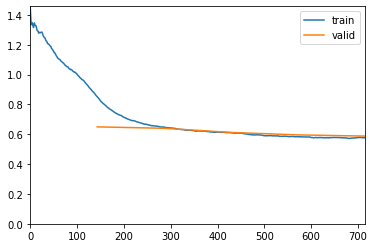

Better model found at epoch 0 with valid_loss value: 0.6497185230255127.
Better model found at epoch 1 with valid_loss value: 0.6402419209480286.
Better model found at epoch 2 with valid_loss value: 0.6123796701431274.
Better model found at epoch 3 with valid_loss value: 0.5959317684173584.
Better model found at epoch 4 with valid_loss value: 0.587891697883606.


In [0]:
learn.fit_one_cycle(5,callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.578469,0.576391,0.314044,0.685956,05:38
1,0.572707,0.599921,0.313106,0.686894,05:31
2,0.555900,0.565090,0.287144,0.712856,05:31
3,0.540690,0.545334,0.278073,0.721927,05:30
4,0.536230,0.551861,0.282452,0.717548,05:31


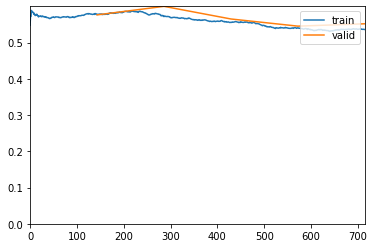

Better model found at epoch 0 with valid_loss value: 0.5763911008834839.
Better model found at epoch 2 with valid_loss value: 0.5650898218154907.
Better model found at epoch 3 with valid_loss value: 0.5453336238861084.


In [0]:
learn.fit_one_cycle(5,callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [0]:
learn.save('resnet34-stage-1')

### The 2nd training

In [0]:
learn.load('resnet34-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (36808 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
1,1,1,1,1
Path: /tmp/MURA-v1.1/data2;

Valid: LabelList (3197 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
1,1,1,1,1
Path: /tmp/MURA-v1.1/data2;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [0]:
learn.purge()
learn.unfreeze()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


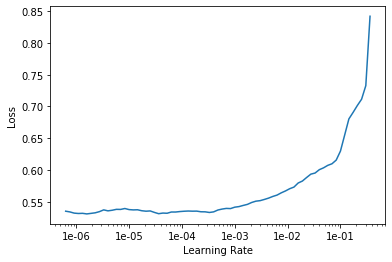

In [0]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.531233,0.549878,0.280263,0.719737,05:22
1,0.525403,0.542315,0.272130,0.727870,05:09
2,0.517056,0.531801,0.263059,0.736941,05:06
3,0.506388,0.526879,0.256178,0.743822,05:11
4,0.506272,0.522245,0.254927,0.745073,05:14


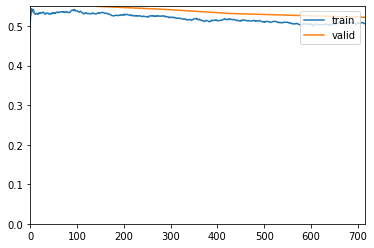

Better model found at epoch 0 with valid_loss value: 0.5498780012130737.
Better model found at epoch 1 with valid_loss value: 0.5423147082328796.
Better model found at epoch 2 with valid_loss value: 0.5318010449409485.
Better model found at epoch 3 with valid_loss value: 0.5268792510032654.
Better model found at epoch 4 with valid_loss value: 0.5222451090812683.


In [0]:
lr=1e-4
learn.fit_one_cycle(5,max_lr=slice(lr/100,lr),callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.501061,0.525364,0.258054,0.741946,05:13
1,0.499999,0.516603,0.253675,0.746325,05:09
2,0.498348,0.512562,0.249922,0.750078,05:05
3,0.484637,0.512622,0.249609,0.750391,05:01
4,0.484520,0.510095,0.248045,0.751955,04:58


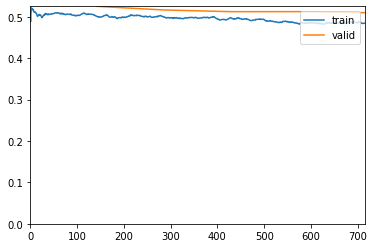

Better model found at epoch 0 with valid_loss value: 0.5253638029098511.
Better model found at epoch 1 with valid_loss value: 0.5166026949882507.
Better model found at epoch 2 with valid_loss value: 0.5125615000724792.
Better model found at epoch 4 with valid_loss value: 0.510094940662384.


In [0]:
lr=1e-4
learn.fit_one_cycle(5,max_lr=slice(lr/100,lr),callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [0]:
learn.save('resnet34-stage-2')

### Look at results of the 2nd training

In [0]:
learn.load('resnet34-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (36808 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
1,1,1,1,1
Path: /tmp/MURA-v1.1/data2;

Valid: LabelList (3197 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
1,1,1,1,1
Path: /tmp/MURA-v1.1/data2;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

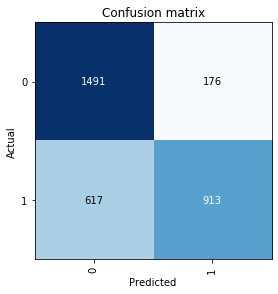

In [0]:
# first interpretation
interp.plot_confusion_matrix()

In [0]:
interp.most_confused(min_val=2)

[('1', '0', 617), ('0', '1', 176)]

실제로 **정상(0)**이지만 **비정상(1)**으로 예측된 경우가 **1667건** 중 **176건**이며, 

실제로 **비정상(1)**이지만 **정상(0)**으로 예측된 경우가 **1530건** 중 **617건**이다. 

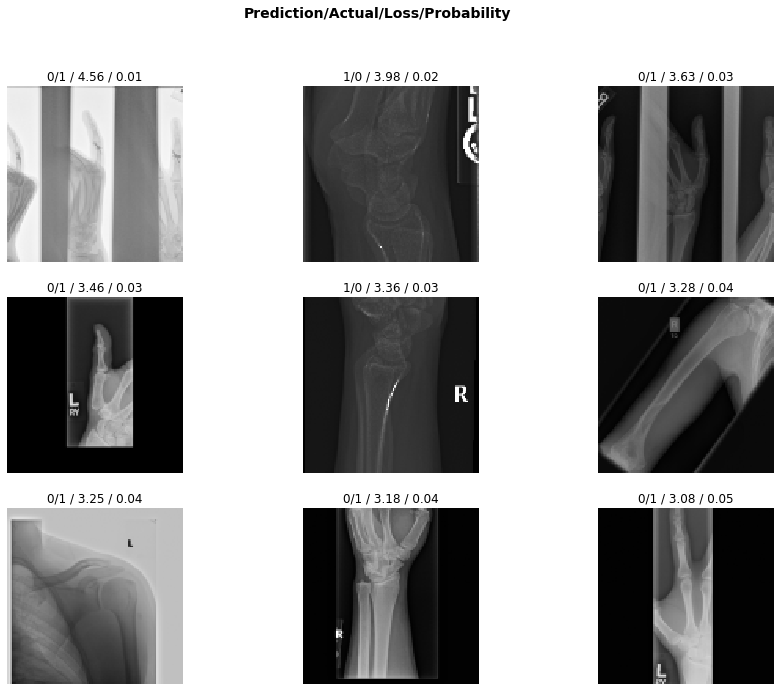

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

### Results by studies

In [0]:
# validation
preds_val, y_val = learn.get_preds()

In [0]:
preds_val

tensor([[0.1057, 0.8943],
        [0.0434, 0.9566],
        [0.6041, 0.3959],
        ...,
        [0.9343, 0.0657],
        [0.7736, 0.2264],
        [0.7545, 0.2455]])

In [0]:
len(preds_val)

3197

In [0]:
for img_url in data.valid_ds.x.items:
    print(img_url)
    break

/tmp/MURA-v1.1/data2/valid/1/WRIST_patient11222_study1_positive_image2.png


In [0]:
pat_label = re.compile(r'/([^/]+)_patient[^/]+.png$')
pat_study = re.compile(r'/([^/]+)_[^_]+.png$')

In [0]:
%%time
studies = dict()
studies_num = dict()
labels = dict()
labels_num = dict()

for m in mura:
    labels_num[m] = 0

for idx, src in enumerate(data.valid_ds.x.items):
    # get label name
    label = pat_label.search(str(src))
    label = label.group(1) 
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1) 
    # sum probabilities by study
    if study in studies:
        studies[study] += preds_val[idx,:].clone()
        studies_num[study] += 1
    else:
        studies[study] = preds_val[idx,:].clone()
        studies_num[study] = 1
    labels[study] = label

CPU times: user 73.2 ms, sys: 559 µs, total: 73.8 ms
Wall time: 75.4 ms


In [0]:
labels_num = dict()
for m in mura:
    labels_num[m] = sum([1 for k,v in labels.items() if v.lower() == m])

In [0]:
print(labels_num)
print(sum([v for k,v in labels_num.items()]))

{'elbow': 158, 'finger': 175, 'forearm': 133, 'hand': 167, 'humerus': 135, 'shoulder': 194, 'wrist': 237}
1199


In [0]:
len(studies)

1199

In [0]:
len(studies_num)

1199

In [0]:
# get averages
for (k,v) in studies.items():
    studies[k] = studies[k] / studies_num[k]

In [0]:
# get predictions by study
acc = 0.
for (k,v) in studies.items():
    prob, y_hat = torch.max(studies[k],0)
    if 'negative' in k:
        acc += (0 == y_hat.item())
    else:
        acc += (1 == y_hat.item())
    # print(f'{k} {y_hat.item()} ({prob})')

In [0]:
len(studies), acc

(1199, 915.0)

In [0]:
# get study accuracy total
print(f'study accuracy total: {round(acc / len(studies),3)}')

study accuracy total: 0.763


In [0]:
# get predictions by study and label
acc_label = dict()
for m in mura:
    acc_label[m] = 0
    
for (k,v) in studies.items():
    prob, y_hat = torch.max(studies[k],0)
    label = labels[k]
    if 'negative' in k:
        acc_label[label.lower()] += (0 == y_hat.item())
    else:
        acc_label[label.lower()] += (1 == y_hat.item())

In [0]:
acc_label

{'elbow': 125,
 'finger': 124,
 'forearm': 106,
 'hand': 116,
 'humerus': 111,
 'shoulder': 145,
 'wrist': 188}

In [0]:
sum([v for k,v in acc_label.items()])

915

In [0]:
labels_num

{'elbow': 158,
 'finger': 175,
 'forearm': 133,
 'hand': 167,
 'humerus': 135,
 'shoulder': 194,
 'wrist': 237}

In [0]:
# get study accuracy by label
for m in mura:
    print(f'{m}: {round(acc_label[m] / labels_num[m],3)}')

elbow: 0.791
finger: 0.709
forearm: 0.797
hand: 0.695
humerus: 0.822
shoulder: 0.747
wrist: 0.793


## Training with Resnet 34 with new setting

### **The 3rd traninig** with size=224

In [0]:
learn = None
gc.collect()

32067

In [0]:
torch.cuda.empty_cache()

In [0]:
size = 224
bs = 128

np.random.seed(42)
data = ImageDataBunch.from_folder(path + 'data2', ds_tfms=get_transforms(flip_vert=True, max_warp=0.), 
                                  size=size, bs=bs, 
                                  ).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], wd=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 85.2MB/s]


In [0]:
learn.load('resnet34-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (36808 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,1,1,1
Path: /tmp/MURA-v1.1/data2;

Valid: LabelList (3197 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,1,1,1
Path: /tmp/MURA-v1.1/data2;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.516734,0.532449,0.250235,0.749765,06:24
1,0.499021,0.492741,0.228026,0.771974,06:22
2,0.486250,0.490420,0.226775,0.773225,06:16
3,0.470252,0.476765,0.219268,0.780732,06:14
4,0.464374,0.472134,0.222083,0.777917,06:20


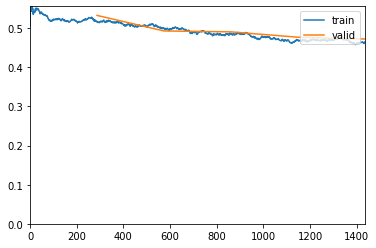

Better model found at epoch 0 with valid_loss value: 0.5324486494064331.
Better model found at epoch 1 with valid_loss value: 0.4927407205104828.
Better model found at epoch 2 with valid_loss value: 0.4904197156429291.
Better model found at epoch 3 with valid_loss value: 0.4767652750015259.
Better model found at epoch 4 with valid_loss value: 0.4721335172653198.


In [0]:
learn.fit_one_cycle(5,callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [0]:
learn.save('resnet34-stage-3');

In [0]:
learn = None
gc.collect()
torch.cuda.empty_cache()


In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], wd=0.1)
learn.load('resnet34-stage-3');

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


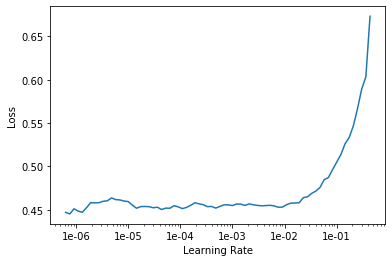

In [0]:
learn.recorder.plot()

### The 4th Training with tuned lr range

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.456191,0.476098,0.218017,0.781983,06:31
1,0.461410,0.467238,0.210510,0.789490,06:36
2,0.461840,0.469575,0.214889,0.785111,06:35
3,0.455688,0.469094,0.212387,0.787613,06:35
4,0.455783,0.467496,0.213638,0.786362,06:35


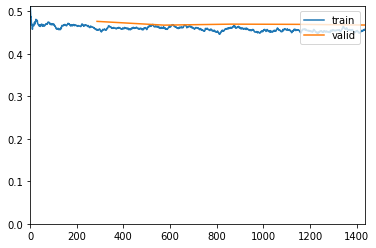

Better model found at epoch 0 with valid_loss value: 0.47609758377075195.
Better model found at epoch 1 with valid_loss value: 0.46723800897598267.


In [0]:
lr = 3e-4
learn.fit_one_cycle(5,max_lr=lr,callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [0]:
learn.save('resnet34-stage-4')

In [0]:
learn.load('resnet34-stage-4');

In [0]:
learn.purge()
learn.unfreeze()


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


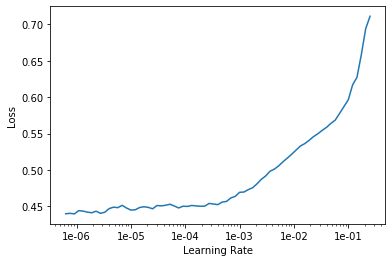

In [0]:
learn.recorder.plot()

### The 5th training with retuned lr range

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.462678,0.468272,0.210197,0.789803,06:43
1,0.459398,0.469186,0.211448,0.788552,06:45
2,0.459971,0.465250,0.212074,0.787926,06:43
3,0.459331,0.468309,0.209571,0.790429,06:45
4,0.454570,0.465658,0.211761,0.788239,06:35


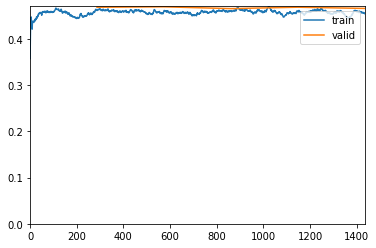

Better model found at epoch 0 with valid_loss value: 0.46827203035354614.
Better model found at epoch 2 with valid_loss value: 0.46524977684020996.


In [0]:
lr=3e-6
learn.fit_one_cycle(5,max_lr=slice(lr/100,lr),callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [0]:
learn.save('resnet34-stage-5')

### Results from the 5th training 

### Results by images

In [0]:
size = 224
bs = 128

np.random.seed(42)
data = ImageDataBunch.from_folder(path + 'data2', ds_tfms=get_transforms(flip_vert=True, max_warp=0.), 
                                  size=size, bs=bs, 
                                  ).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], wd=0.1)

In [0]:
learn.load('./content/gdrive/My Drive/Deep_Learning/Torch/MyTorch/template/fastai/MURA_models/resnet34-stage-5.pth');

FileNotFoundError: ignored

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

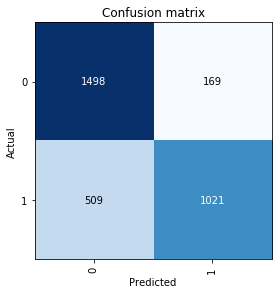

In [0]:
# first interpretation
interp.plot_confusion_matrix()

In [0]:
interp.most_confused(min_val=2)

[('1', '0', 509), ('0', '1', 169)]

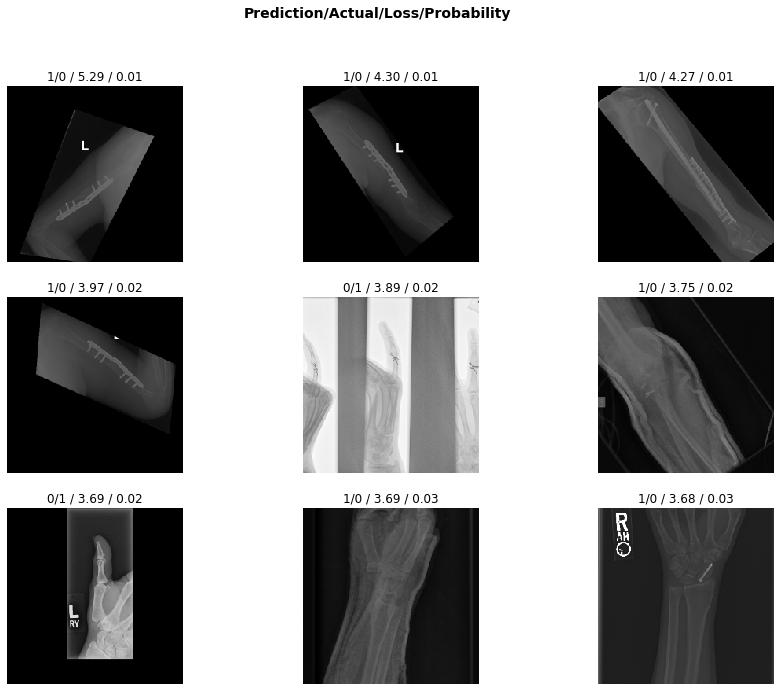

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

### Results by studies

In [0]:
# validation
preds_val, y_val = learn.get_preds()

In [0]:
preds_val

tensor([[0.0878, 0.9122],
        [0.0286, 0.9714],
        [0.6758, 0.3242],
        ...,
        [0.9372, 0.0628],
        [0.7855, 0.2145],
        [0.7954, 0.2046]])

In [0]:
len(preds_val)

3197

In [0]:
for img_url in data.valid_ds.x.items:
    print(img_url)
    break

/tmp/MURA-v1.1/data2/valid/1/WRIST_patient11222_study1_positive_image2.png


In [0]:
pat_label = re.compile(r'/([^/]+)_patient[^/]+.png$')
pat_study = re.compile(r'/([^/]+)_[^_]+.png$')

In [0]:
%%time
studies = dict()
studies_num = dict()
labels_num = dict()

for m in mura:
    labels_num[m] = 0

for idx, src in enumerate(data.valid_ds.x.items):
    # get label name
    label = pat_label.search(str(src))
    label = label.group(1) 
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1) 
    # sum probabilities by study
    if study in studies:
        studies[study] += preds_val[idx,:].clone()
        studies_num[study] += 1
    else:
        studies[study] = preds_val[idx,:].clone()
        studies_num[study] = 1
    label[study] = label

TypeError: ignored

In [0]:
labels_num = dict()
for m in mura:
    labels_num[m] = sum([1 for k,v in labels.items() if v.lower() == m])